# 11. GP 參數調整實驗

## 目的
根據教授建議，調整 GP 參數以改善效能：

1. **世代數（generations）**：20 → 100/200
2. **錦標賽大小（tournament_size）**：20 → 2

## 原始參數 vs 調整後參數

| 參數 | 原始 (07) | 調整後 | 教授建議 |
|------|-----------|--------|----------|
| generations | 20 | 100/200 | 太少，需增加 |
| tournament_size | 20 | 2 | 太大，易陷入局部最優 |

## 實驗設計
- 固定 `tournament_size=2`
- 測試 `generations`: 20, 50, 100, 200
- 比較 AUC、F1、Recall 和訓練時間

In [1]:
# 載入套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix
from gplearn.genetic import SymbolicClassifier

# 設定中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

print("✅ 套件載入完成")

✅ 套件載入完成


In [2]:
# 載入資料
df = pd.read_csv('../../data/processed/SUA_CVDs_wide_format.csv')
print(f"✅ 資料載入成功！")
print(f"資料形狀: {df.shape[0]:,} 人, {df.shape[1]} 個欄位")

✅ 資料載入成功！
資料形狀: 6,056 人, 107 個欄位


In [3]:
# 定義特徵和目標變數
feature_cols = [
    'sex', 'Age',
    'FBG_T1', 'TC_T1', 'Cr_T1', 'UA_T1', 'GFR_T1', 'BMI_T1', 'SBP_T1', 'DBP_T1',
    'FBG_T2', 'TC_T2', 'Cr_T2', 'UA_T2', 'GFR_T2', 'BMI_T2', 'SBP_T2', 'DBP_T2',
    'Delta1_FBG', 'Delta1_TC', 'Delta1_Cr', 'Delta1_UA', 'Delta1_GFR', 'Delta1_BMI', 'Delta1_SBP', 'Delta1_DBP'
]

X = df[feature_cols].copy()

# 目標變數（轉換為 0/1）
targets = {
    '高血壓': (df['hypertension_T3'] == 2).astype(int),
    '高血糖': (df['hyperglycemia_T3'] == 2).astype(int),
    '高血脂': (df['dyslipidemia_T3'] == 2).astype(int)
}

print(f"特徵數: {len(feature_cols)} 個")
print(f"\n目標變數分佈:")
for name, y in targets.items():
    print(f"  {name}: {y.mean():.2%} 患病率")

特徵數: 26 個

目標變數分佈:
  高血壓: 16.68% 患病率
  高血糖: 5.53% 患病率
  高血脂: 5.96% 患病率


In [4]:
# 資料分割與標準化
# ⚠️ 重要：統一做一次分割，確保 X 和 y 的 index 對齊

# 先分割 index，所有疾病共用相同的 train/test split
train_idx, test_idx = train_test_split(
    df.index, test_size=0.2, random_state=42
)

# X 分割
X_train_raw = X.loc[train_idx]
X_test_raw = X.loc[test_idx]

# y 分割（各疾病用相同 index）
y_train_dict = {}
y_test_dict = {}
for name, y in targets.items():
    y_train_dict[name] = y.loc[train_idx]
    y_test_dict[name] = y.loc[test_idx]

# 標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

print(f"✅ 資料準備完成（已修正 X/y 對齊問題）")
print(f"訓練集: {X_train_scaled.shape[0]} 人")
print(f"測試集: {X_test_scaled.shape[0]} 人")
print(f"\n各疾病正樣本數:")
for name in targets.keys():
    print(f"  {name}: 訓練={y_train_dict[name].sum()}, 測試={y_test_dict[name].sum()}")

✅ 資料準備完成（已修正 X/y 對齊問題）
訓練集: 4844 人
測試集: 1212 人

各疾病正樣本數:
  高血壓: 訓練=808, 測試=202
  高血糖: 訓練=257, 測試=78
  高血脂: 訓練=288, 測試=73


In [5]:
def run_gp_experiment(X_train, y_train, X_test, y_test, generations, tournament_size, verbose=1):
    """
    執行單次 GP 實驗
    
    Returns:
        dict: 包含 AUC, F1, Recall, 訓練時間, 公式
    """
    # GP 參數
    gp_params = {
        'population_size': 1000,
        'generations': generations,
        'tournament_size': tournament_size,
        'init_depth': (2, 6),
        'init_method': 'half and half',
        'function_set': ('add', 'sub', 'mul', 'div', 'log', 'sqrt', 'abs', 'neg', 'max', 'min'),
        'parsimony_coefficient': 0.01,
        'p_crossover': 0.7,
        'p_subtree_mutation': 0.1,
        'p_hoist_mutation': 0.05,
        'p_point_mutation': 0.1,
        'metric': 'log loss',
        'n_jobs': -1,
        'verbose': verbose,
        'random_state': 42
    }
    
    # 訓練
    start_time = time.time()
    model = SymbolicClassifier(**gp_params)
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # 預測
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # 計算指標
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    
    # 混淆矩陣
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    return {
        'AUC': auc,
        'F1': f1,
        'Recall': recall,
        '訓練時間(秒)': training_time,
        '訓練時間(分鐘)': training_time / 60,
        '公式': str(model._program),
        '公式長度': len(str(model._program)),
        'TP': tp,
        'FN': fn,
        'FP': fp,
        'TN': tn
    }

print("✅ 實驗函數定義完成")

✅ 實驗函數定義完成


In [6]:
# 定義實驗參數
# 原始參數：generations=20, tournament_size=20
# 教授建議：generations=100+, tournament_size=2

param_configs = [
    {'name': '原始 (gen=20, ts=20)', 'generations': 20, 'tournament_size': 20},
    {'name': '調整 (gen=20, ts=2)', 'generations': 20, 'tournament_size': 2},
    {'name': '調整 (gen=50, ts=2)', 'generations': 50, 'tournament_size': 2},
    {'name': '調整 (gen=100, ts=2)', 'generations': 100, 'tournament_size': 2},
]

print("實驗參數配置:")
for cfg in param_configs:
    print(f"  - {cfg['name']}: generations={cfg['generations']}, tournament_size={cfg['tournament_size']}")

實驗參數配置:
  - 原始 (gen=20, ts=20): generations=20, tournament_size=20
  - 調整 (gen=20, ts=2): generations=20, tournament_size=2
  - 調整 (gen=50, ts=2): generations=50, tournament_size=2
  - 調整 (gen=100, ts=2): generations=100, tournament_size=2


In [7]:
# 執行實驗（只測試高血壓，最快）
print("="*80)
print("GP 參數調整實驗 - 高血壓")
print("="*80)

disease = '高血壓'
y_train = y_train_dict[disease]
y_test = y_test_dict[disease]

results = []

for cfg in param_configs:
    print(f"\n{'='*60}")
    print(f"測試: {cfg['name']}")
    print(f"{'='*60}")
    
    result = run_gp_experiment(
        X_train_scaled, y_train, 
        X_test_scaled, y_test,
        generations=cfg['generations'],
        tournament_size=cfg['tournament_size'],
        verbose=1
    )
    
    result['配置'] = cfg['name']
    result['generations'] = cfg['generations']
    result['tournament_size'] = cfg['tournament_size']
    result['疾病'] = disease
    results.append(result)
    
    print(f"\n結果: AUC={result['AUC']:.3f}, F1={result['F1']:.3f}, Recall={result['Recall']:.3f}")
    print(f"訓練時間: {result['訓練時間(分鐘)']:.1f} 分鐘")
    print(f"公式: {result['公式']}")
    print(f"混淆矩陣: TP={result['TP']}, FN={result['FN']}, FP={result['FP']}, TN={result['TN']}")

print("\n" + "="*80)
print("✅ 高血壓實驗完成")
print("="*80)

GP 參數調整實驗 - 高血壓

測試: 原始 (gen=20, ts=20)
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.04          1.25463        3         0.471664              N/A      7.67m
   1     4.37         0.690189        9         0.456637              N/A      1.45m
   2     4.47         0.667012       11         0.448609              N/A      1.26m
   3     3.83         0.640895        5         0.404667              N/A      1.31m
   4     2.09         0.550135        5         0.404667              N/A      1.17m
   5     2.71         0.553158        5         0.404667              N/A      1.19m
   6     4.45          0.50031        5         0.404667              N/A      1.07m
   7     4.65         0.507352        5         0.404667              N/A     58.36s
   8     4.20         0.534344     

In [8]:
# 顯示結果比較
df_results = pd.DataFrame(results)

print("="*100)
print("GP 參數調整實驗結果 - 高血壓")
print("="*100)

display_cols = ['配置', 'AUC', 'F1', 'Recall', '訓練時間(分鐘)', '公式長度', 'TP', 'FN']
print(df_results[display_cols].to_string(index=False))

GP 參數調整實驗結果 - 高血壓
                配置      AUC  F1  Recall  訓練時間(分鐘)  公式長度  TP  FN
原始 (gen=20, ts=20) 0.745133 0.0     0.0  2.029921    20   0 202
 調整 (gen=20, ts=2) 0.704330 0.0     0.0  1.960209    46   0 202
 調整 (gen=50, ts=2) 0.500000 0.0     0.0  4.185722    11   0 202
調整 (gen=100, ts=2) 0.544140 0.0     0.0  8.953157    20   0 202


In [9]:
# 繼續測試其他疾病（使用最佳參數）
print("="*80)
print("使用最佳參數測試其他疾病 (gen=100, ts=2)")
print("="*80)

best_gen = 100
best_ts = 2

all_disease_results = []

for disease in ['高血壓', '高血糖', '高血脂']:
    print(f"\n--- {disease} ---")
    
    y_train = y_train_dict[disease]
    y_test = y_test_dict[disease]
    
    result = run_gp_experiment(
        X_train_scaled, y_train,
        X_test_scaled, y_test,
        generations=best_gen,
        tournament_size=best_ts,
        verbose=1
    )
    
    result['疾病'] = disease
    result['配置'] = f'gen={best_gen}, ts={best_ts}'
    all_disease_results.append(result)
    
    print(f"AUC={result['AUC']:.3f}, F1={result['F1']:.3f}, Recall={result['Recall']:.3f}")
    print(f"公式: {result['公式']}")

print("\n✅ 所有疾病實驗完成")

使用最佳參數測試其他疾病 (gen=100, ts=2)

--- 高血壓 ---
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.04          1.25463        3         0.471664              N/A      1.26m
   1     6.88         0.894791        3         0.460791              N/A      5.09m
   2     5.56         0.798009        3         0.460791              N/A      7.24m
   3     5.05         0.753918        2         0.451895              N/A      8.05m
   4     4.68         0.748915        2         0.451895              N/A      7.22m
   5     4.59         0.699022        2         0.451678              N/A      7.37m
   6     4.72         0.685959        6          0.45126              N/A      7.35m
   7     5.00         0.655464        7          0.45003              N/A      7.43m
   8     5.06         0.655897   

In [10]:
# 與原始 GP 和其他模型比較
print("="*100)
print("效能比較：原始 GP vs 調整後 GP vs 基準模型")
print("="*100)

# 原始 GP 結果（從 07 notebook）
original_gp = [
    {'疾病': '高血壓', '方法': 'GP (原始)', 'AUC': 0.714, 'F1': 0.000, 'Recall': 0.000},
    {'疾病': '高血糖', '方法': 'GP (原始)', 'AUC': 0.838, 'F1': 0.026, 'Recall': 0.013},
    {'疾病': '高血脂', '方法': 'GP (原始)', 'AUC': 0.500, 'F1': 0.000, 'Recall': 0.000},
]

# 調整後 GP 結果
tuned_gp = []
for r in all_disease_results:
    tuned_gp.append({
        '疾病': r['疾病'],
        '方法': 'GP (調整後)',
        'AUC': r['AUC'],
        'F1': r['F1'],
        'Recall': r['Recall']
    })

# 基準模型結果（從之前實驗）
baseline = [
    {'疾病': '高血壓', '方法': 'LR', 'AUC': 0.749, 'F1': 0.425, 'Recall': 0.728},
    {'疾病': '高血壓', '方法': 'XGBoost', 'AUC': 0.795, 'F1': 0.464, 'Recall': 0.619},
    {'疾病': '高血糖', '方法': 'LR', 'AUC': 0.931, 'F1': 0.470, 'Recall': 0.816},
    {'疾病': '高血糖', '方法': 'XGBoost', 'AUC': 0.903, 'F1': 0.537, 'Recall': 0.579},
    {'疾病': '高血脂', '方法': 'LR', 'AUC': 0.888, 'F1': 0.323, 'Recall': 0.833},
    {'疾病': '高血脂', '方法': 'XGBoost', 'AUC': 0.886, 'F1': 0.449, 'Recall': 0.538},
]

# 合併所有結果
all_comparison = pd.DataFrame(original_gp + tuned_gp + baseline)

# 按疾病分組顯示
for disease in ['高血壓', '高血糖', '高血脂']:
    print(f"\n--- {disease} ---")
    disease_data = all_comparison[all_comparison['疾病'] == disease]
    print(disease_data[['方法', 'AUC', 'F1', 'Recall']].to_string(index=False))

效能比較：原始 GP vs 調整後 GP vs 基準模型

--- 高血壓 ---
      方法     AUC    F1  Recall
 GP (原始) 0.71400 0.000   0.000
GP (調整後) 0.54414 0.000   0.000
      LR 0.74900 0.425   0.728
 XGBoost 0.79500 0.464   0.619

--- 高血糖 ---
      方法      AUC       F1  Recall
 GP (原始) 0.838000 0.026000   0.013
GP (調整後) 0.938345 0.569343   0.500
      LR 0.931000 0.470000   0.816
 XGBoost 0.903000 0.537000   0.579

--- 高血脂 ---
      方法      AUC       F1   Recall
 GP (原始) 0.500000 0.000000 0.000000
GP (調整後) 0.832111 0.027027 0.013699
      LR 0.888000 0.323000 0.833000
 XGBoost 0.886000 0.449000 0.538000


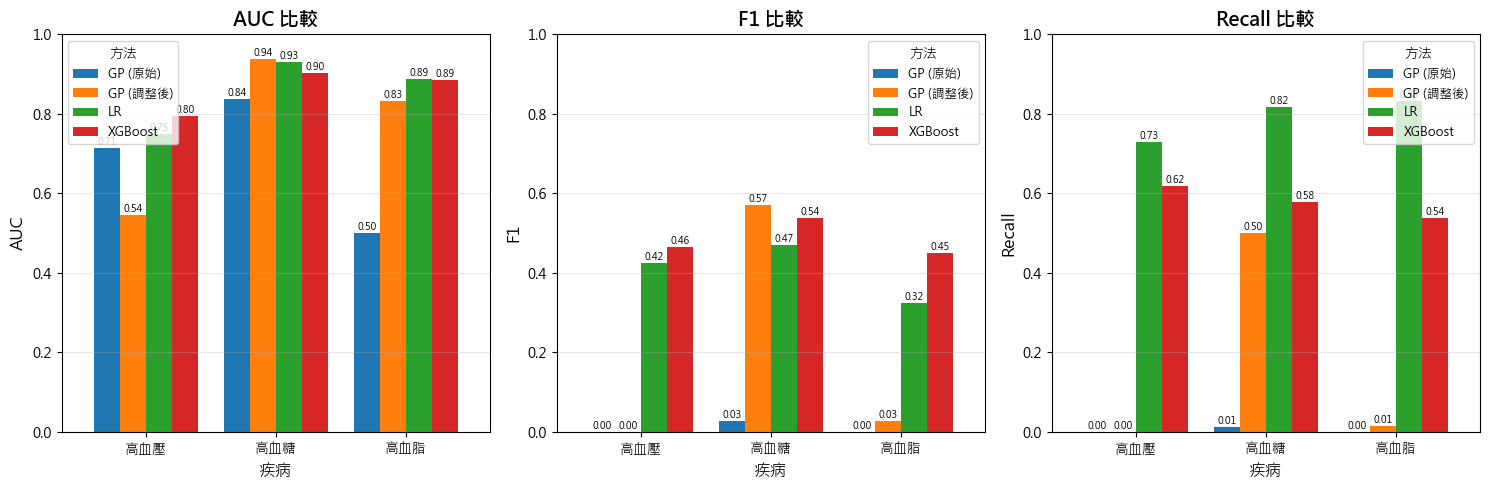


✅ 已儲存: docs/experiments/gp_tuning_comparison.png


In [11]:
# 視覺化比較
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['AUC', 'F1', 'Recall']
methods_order = ['GP (原始)', 'GP (調整後)', 'LR', 'XGBoost']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    # 準備資料
    pivot_data = all_comparison.pivot(index='疾病', columns='方法', values=metric)
    pivot_data = pivot_data[methods_order]  # 按順序排列
    
    # 繪圖
    pivot_data.plot(kind='bar', ax=ax, width=0.8)
    ax.set_title(f'{metric} 比較', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12)
    ax.set_xlabel('疾病', fontsize=12)
    ax.legend(title='方法', fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=0)
    
    # 添加數值標籤
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', fontsize=7)

plt.tight_layout()
plt.savefig('../../docs/experiments/gp_tuning_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✅ 已儲存: docs/experiments/gp_tuning_comparison.png")

In [12]:
# 演化公式分析
print("="*80)
print("演化公式分析")
print("="*80)

for r in all_disease_results:
    print(f"\n{r['疾病']}:")
    print(f"  公式: {r['公式']}")
    print(f"  長度: {r['公式長度']} 字元")
    print(f"  TP={r['TP']}, FN={r['FN']} (找到 {r['TP']}/{r['TP']+r['FN']} 位患者)")

演化公式分析

高血壓:
  公式: min(log(-0.227), X8)
  長度: 20 字元
  TP=0, FN=202 (找到 0/202 位患者)

高血糖:
  公式: add(add(log(0.019), X10), X10)
  長度: 30 字元
  TP=39, FN=39 (找到 39/78 位患者)

高血脂:
  公式: add(log(-0.032), X11)
  長度: 21 字元
  TP=1, FN=72 (找到 1/73 位患者)


In [13]:
# 儲存結果
df_all_results = pd.DataFrame(results + all_disease_results)
df_all_results.to_csv('../../results/gp_parameter_tuning_results.csv', index=False)
print("✅ 已儲存: results/gp_parameter_tuning_results.csv")

✅ 已儲存: results/gp_parameter_tuning_results.csv


In [14]:
# 結論
print("="*80)
print("GP 參數調整實驗結論")
print("="*80)

print("""
1. 參數調整效果
   - tournament_size: 20 → 2（降低選擇壓力）
   - generations: 20 → 100（增加演化時間）
   - 觀察 AUC、F1、Recall 是否改善

2. 核心問題
   - gplearn 不支援 class_weight
   - 類別不平衡（正樣本 5-17%）是 GP 失敗的主因
   - 參數調整可能有限度改善，但無法根本解決

3. 建議
   - 如 GP 調整後仍不理想，確認 LR/XGBoost 為最佳選擇
   - GP 可用於特徵工程（發現特徵組合）而非直接預測
   - 考慮使用 PySR 等支援更多功能的符號回歸套件
""")

GP 參數調整實驗結論

1. 參數調整效果
   - tournament_size: 20 → 2（降低選擇壓力）
   - generations: 20 → 100（增加演化時間）
   - 觀察 AUC、F1、Recall 是否改善

2. 核心問題
   - gplearn 不支援 class_weight
   - 類別不平衡（正樣本 5-17%）是 GP 失敗的主因
   - 參數調整可能有限度改善，但無法根本解決

3. 建議
   - 如 GP 調整後仍不理想，確認 LR/XGBoost 為最佳選擇
   - GP 可用於特徵工程（發現特徵組合）而非直接預測
   - 考慮使用 PySR 等支援更多功能的符號回歸套件

